In [1]:
import os
import numpy as np
import pandas as pd
from lumicks import pylake
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def get_kymo_distance(marker, kymo):
    """
    Get the distance data for a kymograph.

    :param marker: Pylake File object containing marker data.
    :param kymo: Kymograph object.
    :return: Upsampled distance data.
    """
    marker_time_ns = marker['Force LF']['Trap 1'].timestamps
    marker_distance = marker['Distance']['Distance 1'].data
    kymo_start_time = min(kymo.timestamps[:][0])
    kymo_end_time = max(kymo.timestamps[:][0])
    kymo_time_ns = (marker_time_ns >= kymo_start_time) & (marker_time_ns <= kymo_end_time)
    kymo_distance = marker_distance[kymo_time_ns]
    time = np.linspace(0, 1, len(kymo_distance))
    new_time = np.linspace(0, 1, kymo.shape[1])
    f = interp1d(time, kymo_distance, kind='linear')
    upsampled_distance = f(new_time)
    return upsampled_distance

def get_kymo_force(marker, kymo):
    """
    Get the distance data for a kymograph.

    :param marker: Pylake File object containing marker data.
    :param kymo: Kymograph object.
    :return: Upsampled force data.
    """
    marker_time_ns = marker['Force LF']['Trap 1'].timestamps
    marker_force = marker['Force LF']['Force 2x'].data
    kymo_start_time = min(kymo.timestamps[:][0])
    kymo_end_time = max(kymo.timestamps[:][0])
    kymo_time_ns = (marker_time_ns >= kymo_start_time) & (marker_time_ns <= kymo_end_time)
    kymo_force = marker_force[kymo_time_ns]
    time = np.linspace(0, 1, len(kymo_force))
    new_time = np.linspace(0, 1, kymo.shape[1])
    f = interp1d(time, kymo_force, kind='linear')
    upsampled_force = f(new_time)
    return upsampled_force

def process_kymographs(data_folder, marker_name, bead_size=4.35, start_pad=10):
    """
    Process kymographs to detect beads.

    :param data_folder: Path to the data folder.
    :param marker_name: marker.h5 file to process.
    :param bead_size: Size of the beads.
    :param start_pad: Padding at the start of the kymograph.
    """
    adjustment = pylake.ColorAdjustment([0], [10], mode="absolute", gamma=0.5)
    
    marker = pylake.File(os.path.join(data_folder, marker_name))
    for kymo_id in marker.kymos:
        kymo = marker.kymos[kymo_id]
        kymo_img = kymo.get_image()
        kymo_pixel_size_um = kymo.pixelsize_um[0]
        bead_window = int((bead_size /kymo_pixel_size_um) * 1.15)

        bead_radius_pixels = (bead_size / kymo_pixel_size_um) / 2
        kymo_intensity = np.mean(kymo_img[:, :, 1], axis=1)
        if start_pad > 0:
            kymo_intensity = np.append(kymo_intensity[-start_pad:], kymo_intensity)

        rolling_mean = np.convolve(kymo_intensity, np.ones(bead_window) / bead_window, mode='same')
        bead_peaks = find_peaks(rolling_mean, prominence=0, width=15, height=0, distance=100)
        peak_centres = bead_peaks[0]

        left_bead = peak_centres[0] - start_pad

        kymo_distance = get_kymo_distance(marker, kymo)
        kymo_force = get_kymo_force(marker,kymo)
        kymo_duration = kymo.duration
        left_bead_start_array = [(left_bead - bead_radius_pixels)] * len(kymo_distance)
        left_bead_end_array = [(left_bead + bead_radius_pixels)] * len(kymo_distance)
        right_bead_start_array = left_bead_end_array + (kymo_distance/kymo_pixel_size_um)
        right_bead_end_array = left_bead_end_array + (kymo_distance/kymo_pixel_size_um) + (bead_radius_pixels * 2)

        plt.figure(figsize=(7, 10))
        kymo.plot(adjustment=adjustment, aspect='auto')
        #plt.hlines(left_bead_edges, 0, kymo.duration, color='yellow')
        time_axis = np.linspace(0, kymo.duration, kymo.shape[1])
        plt.plot(time_axis, np.array(left_bead_start_array)*kymo_pixel_size_um, color='black')
        plt.plot(time_axis, np.array(left_bead_end_array)*kymo_pixel_size_um, color='black')
        plt.plot(time_axis, np.array(left_bead_start_array)*kymo_pixel_size_um, color='yellow', linestyle='dashed', dashes=(5, 5))
        plt.plot(time_axis, np.array(left_bead_end_array)*kymo_pixel_size_um, color='yellow', linestyle='dashed', dashes=(5, 5))

        plt.plot(time_axis, np.array(right_bead_start_array)*kymo_pixel_size_um, color='black')
        plt.plot(time_axis, np.array(right_bead_end_array)*kymo_pixel_size_um, color='black')
        plt.plot(time_axis, np.array(right_bead_start_array)*kymo_pixel_size_um, color='yellow', linestyle='dashed', dashes=(5, 5))
        plt.plot(time_axis, np.array(right_bead_end_array)*kymo_pixel_size_um, color='yellow', linestyle='dashed', dashes=(5, 5))
        plt.title(marker_name.removesuffix(".h5"))
        plt.show()

        bead_edges_df = {
            'Left_bead_start': left_bead_start_array,
            'Left_bead_end': left_bead_end_array,
            'Right_bead_start': right_bead_start_array,
            'Right_bead_end': right_bead_end_array,
            'Force' : kymo_force,
            'Kymo_time' : kymo_duration
        }
        bead_edges_df = pd.DataFrame(bead_edges_df)
        save_folder = os.path.join(data_folder, 'Bead_locations/')
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        bead_edges_df.to_csv(os.path.join(save_folder, f'{marker_name.removesuffix(".h5")}_kymo_{kymo_id}.csv'))
        

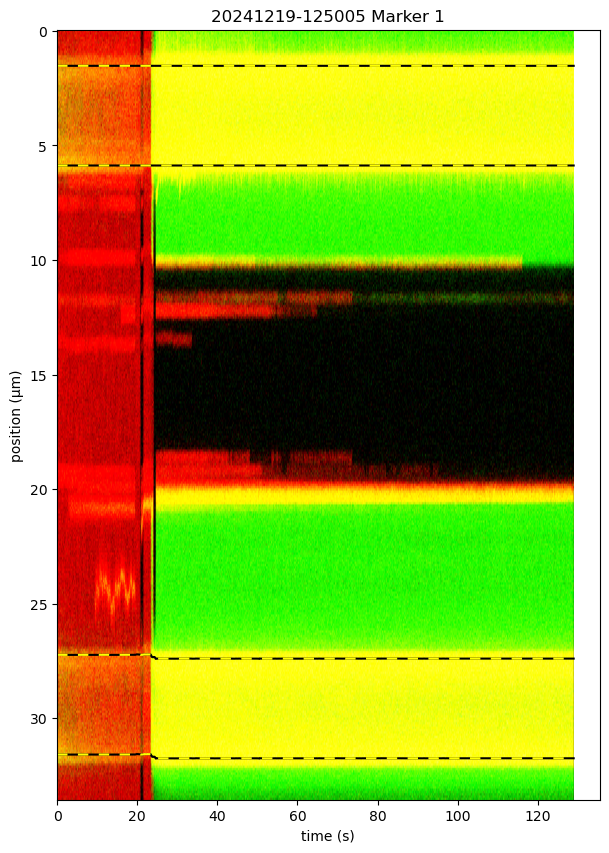

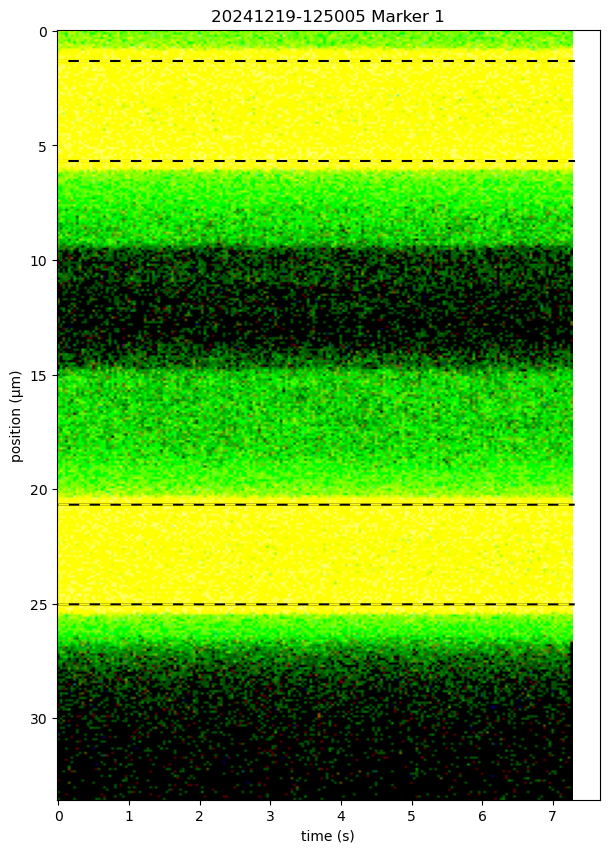

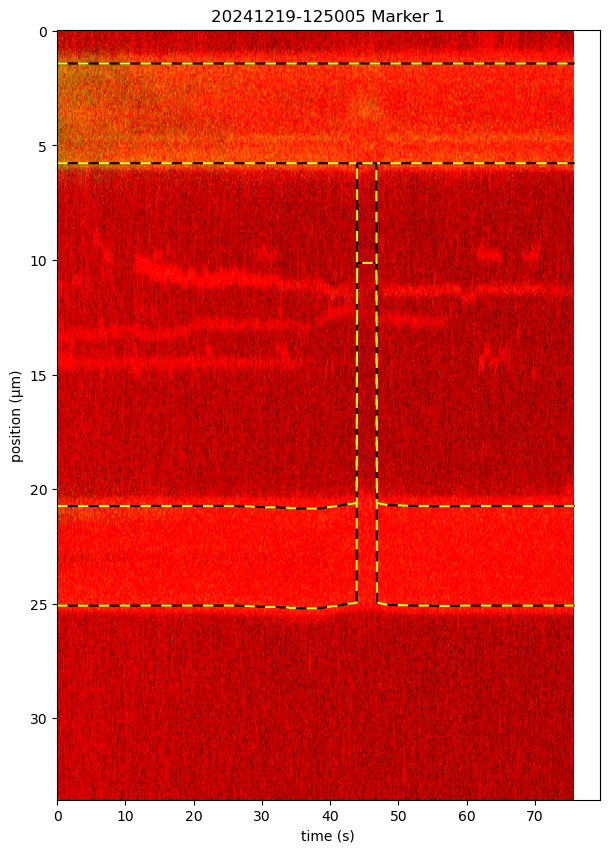

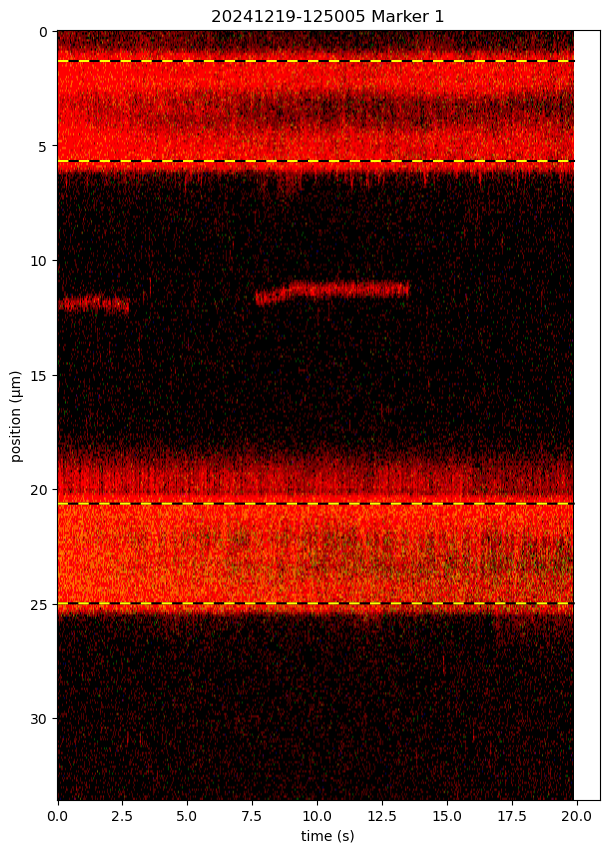

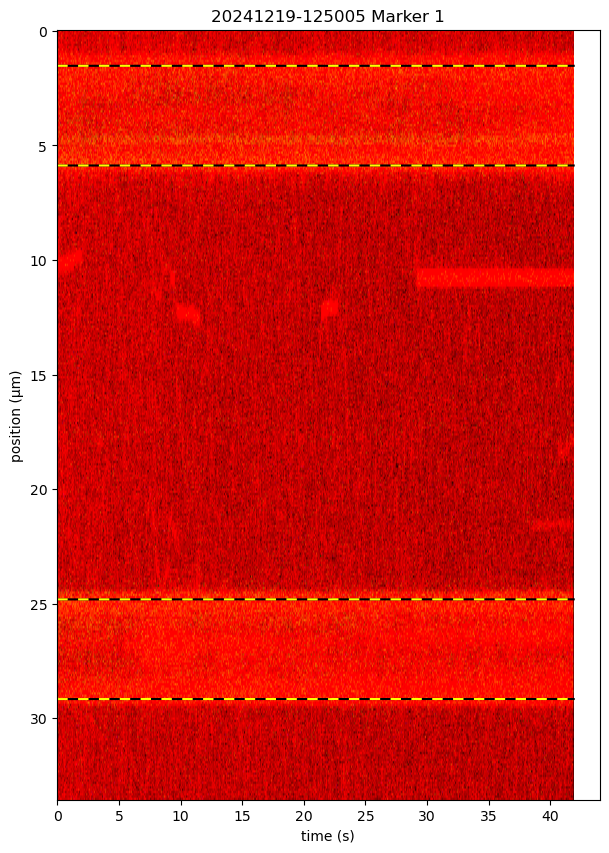

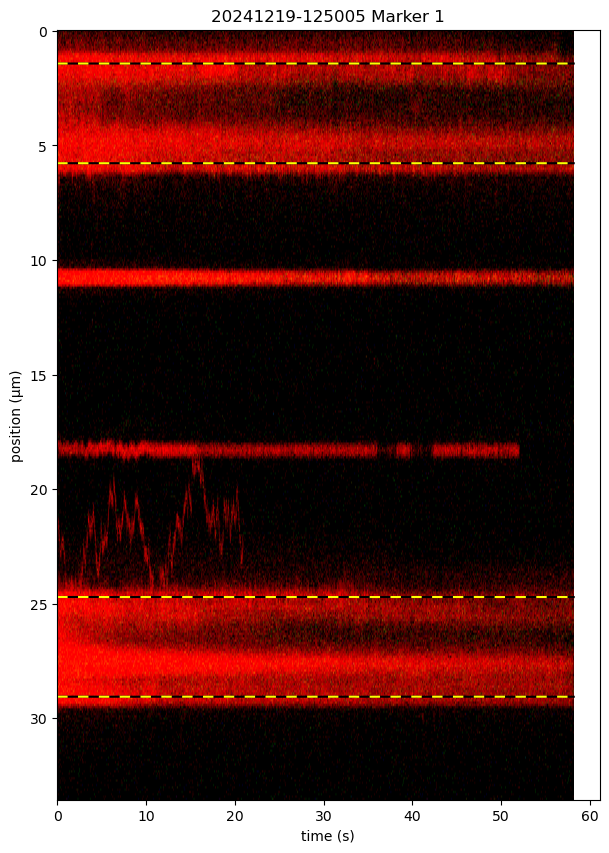

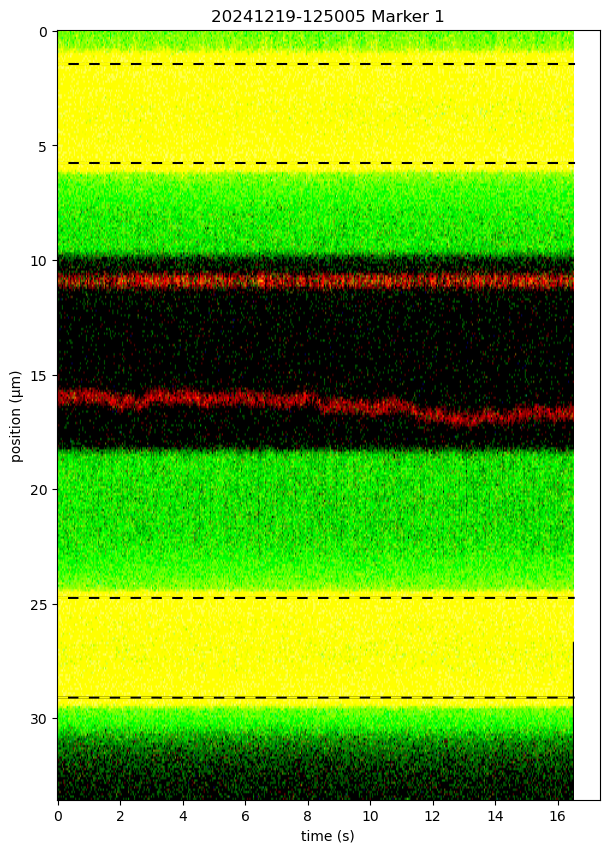

In [3]:
# Define the data folder path and dates to process
data_folder = '../test_folder/'
marker_name = '20241219-125005 Marker 1.h5'
# Process the kymographs to detect beads
process_kymographs(data_folder, marker_name, bead_size=4.35)